# PID Controller Iteractive Design

In [1]:
import micropip
await micropip.install('control')
await micropip.install('ipywidgets')
await micropip.install('ipympl')
await micropip.install('blockdiaglite')

import scipy
import control
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## Terminology

Input function: $R(s)$

Output function: $Y(s)$

Feedforward function: $G(s)$
* Model of the physical system being controlled

Feedback function: $H(s)$
* Model of the sensor being used for feedback
* Ideally $1$ but can be corrected with P controller

Process function: $P(s)=\frac{G(s)}{1+G(s)H(s)-G(s)}$
* Combines feedforward and feedback into a single function

Transfer function: $T(s)=\frac{R(s)}{Y(s)}=\frac{G(s)}{1+G(s)H(s)}=\frac{C(s)P(s)}{1+C(s)P(s)}$
* Transfer function of the entire system

<IPython.core.display.Latex object>

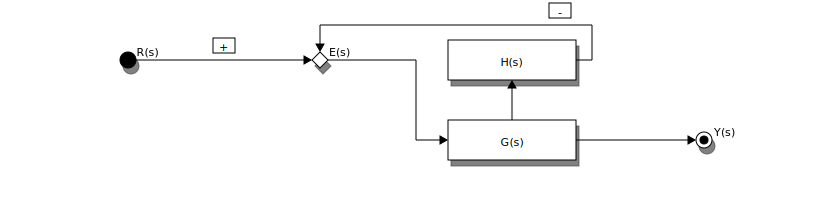

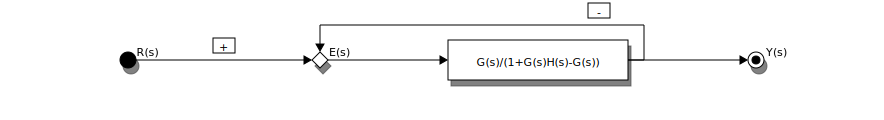

<IPython.core.display.Latex object>

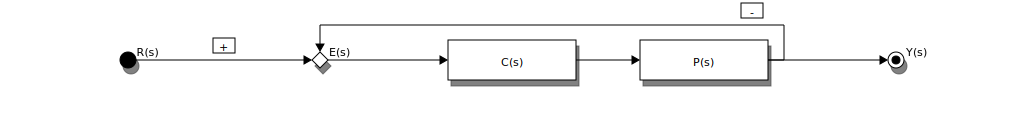

<IPython.core.display.Latex object>

In [2]:
from blockdiag import parser, builder, drawer
from IPython.display import SVG, Latex

# see http://interactive.blockdiag.com/
def create_blockdiag(source) -> SVG:
    tree = parser.parse_string(source)
    diagram = builder.ScreenNodeBuilder.build(tree)
    draw = drawer.DiagramDraw('SVG', diagram)
    draw.drawer.set_options()
    draw.draw()
    return SVG(draw.save())

display(Latex(fr"""
Closed Loop Transfer Function (Non Unity Feedback and Unity Feedback):
"""))
display(create_blockdiag("""
blockdiag {
  R [shape = beginpoint, label="R(s)"];
  Y [shape = endpoint, label="Y(s)"];
  sigma [shape = minidiamond, label="E(s)"];
  group {
    orientation = portrait
    color = white
    G [label = "G(s)"]
    H [label = "H(s)"]
    H <- G;
  }
  R -> sigma [label="+"];
  H -> sigma [label="-"];
  sigma -> G -> Y;
}
"""))
display(create_blockdiag("""
blockdiag {
  R [shape = beginpoint, label="R(s)"];
  Y [shape = endpoint, label="Y(s)"];
  sigma [shape = minidiamond, label="E(s)"];
  GH [label="G(s)/(1+G(s)H(s)-G(s))", width=180];

  R -> sigma [label="+"];
  GH -> sigma [label="-"];
  sigma -> GH -> Y;
}
"""))
display(Latex(fr"""
Conventional Feedback Function with Controller:
"""))
display(create_blockdiag("""
blockdiag {
  R [shape = beginpoint, label="R(s)"];
  Y [shape = endpoint, label="Y(s)"];
  sigma [shape = minidiamond, label="E(s)"];
  C [label="C(s)"];
  P [label="P(s)"];

  R -> sigma [label="+"];
  P -> sigma [label="-"];
  sigma -> C -> P -> Y;
}
"""))
display(Latex(fr"""
Transfer Function:
\begin{{eqnarray}}C(s)=1\end{{eqnarray}}
\begin{{eqnarray}}P(s)=\frac{{G(s)}}{{1+G(s)H(s)-G(s)}}\end{{eqnarray}}
\begin{{eqnarray}}T(s)=\frac{{R(s)}}{{Y(s)}}=\frac{{G(s)}}{{1+G(s)H(s)}}=\frac{{C(s)P(s)}}{{1+C(s)P(s)}}\end{{eqnarray}}
"""))

# Define Process/Plant

In [3]:
G = control.tf(
    (0.075,1,1),
    (1,3,5,0)
)
H = control.tf(
    (1),
    (1)
)
T = control.minreal(G/(1+G*H))

3 states have been removed from the model


<IPython.core.display.Latex object>

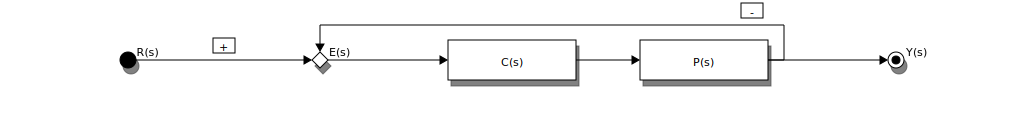

<IPython.core.display.Latex object>

In [4]:
display(Latex(fr"""
Conventional Feedback Function with Controller:
"""))
display(create_blockdiag("""
blockdiag {
  R [shape = beginpoint, label="R(s)"];
  Y [shape = endpoint, label="Y(s)"];
  sigma [shape = minidiamond, label="E(s)"];
  C [label="C(s)"];
  P [label="P(s)"];

  R -> sigma [label="+"];
  P -> sigma [label="-"];
  sigma -> C -> P -> Y;
}
"""))
display(Latex(fr"""
Transfer Function:
\begin{{eqnarray}}C(s)=1\end{{eqnarray}}
\begin{{eqnarray}}P(s)=\frac{{G(s)}}{{1+G(s)H(s)-G(s)}}\end{{eqnarray}}
\begin{{eqnarray}}T(s)=\frac{{G(s)}}{{1+G(s)H(s)}}={T._repr_latex_().lstrip('$').rstrip('$')}\end{{eqnarray}}
"""))

## P Controller

Applying gain to the error $E(s)$ can be expressed via a root locus with the characteristic equation:

<p style="text-align: center;">$1+K \cdot T(s)=0$</p>
<p style="text-align: center;">$T_D(s)+K \cdot T_N(s)=0$</p>

Transfer Function:
<p style="text-align: center;">$C(s) = K_p$</p>
<p style="text-align: center;">$T(s) = \frac{C(s)P(s)}{1 + C(s)P(s)} = \frac{K_p \cdot G(s)}{1+K_p \cdot G(s)H(s)}$</p>

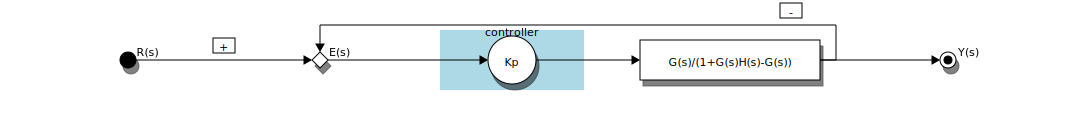

In [5]:
display(create_blockdiag("""
blockdiag {
  R [shape = beginpoint, label="R(s)"];
  Y [shape = endpoint, label="Y(s)"];
  sigma [shape = minidiamond, label="E(s)"];
  group {
    label = controller
    color = lightblue
    Kp [shape = circle, label="Kp"];
  }
  GH [label="G(s)/(1+G(s)H(s)-G(s))", width=180];
  
  R -> sigma [label="+"];
  GH -> sigma [label="-"];
  sigma -> Kp -> GH;
  GH -> Y;
}
"""))

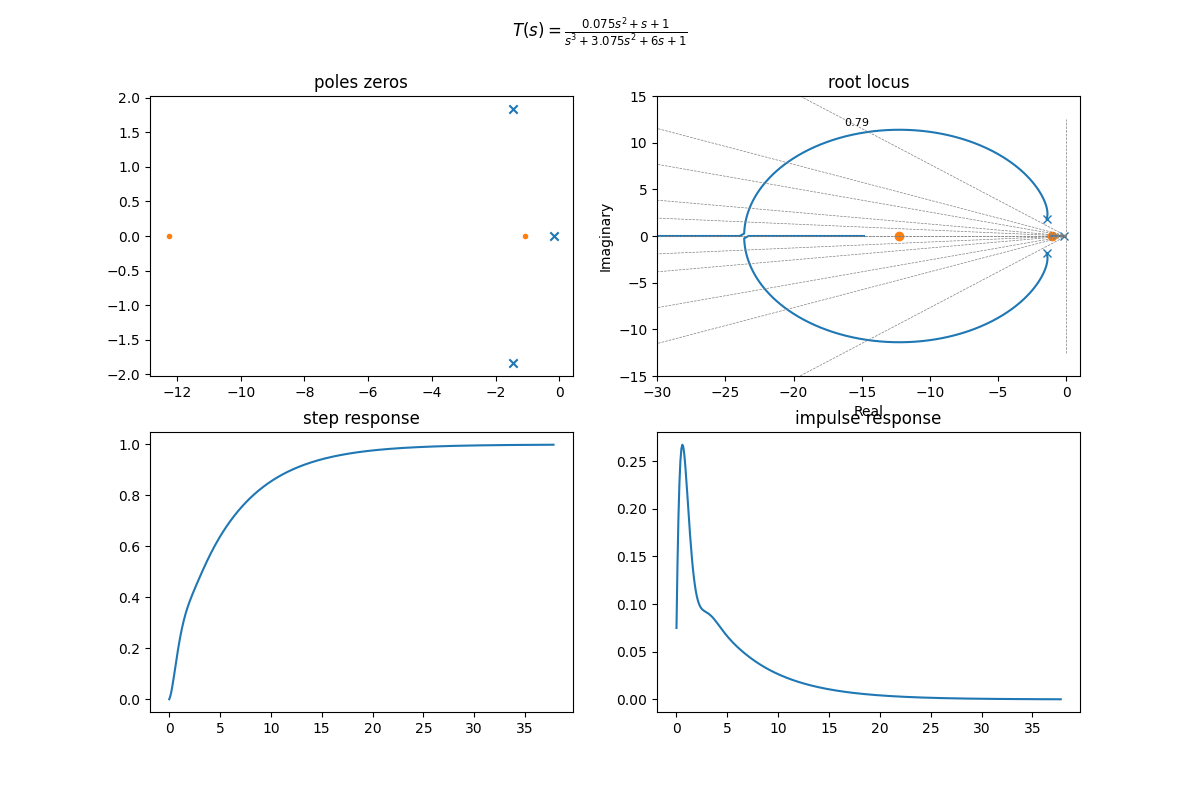

In [10]:
%matplotlib widget

with plt.ioff():
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    fig.suptitle(f"$T(s)={T._repr_latex_().lstrip('$').rstrip('$')}$")
    
# pzmap
ax = axes[0,0]
p, z = control.pzmap(
    T,
    plot=False
)
ax.set_title('poles zeros')
ax.scatter(np.real(p), np.imag(p), marker='x')
ax.scatter(np.real(z), np.imag(z), marker='.')    
    
# root locus
ax = axes[0,1]
rlist, klist = control.rlocus(
    T,
    kvect=np.linspace(1000, 0, num=5000),
    ax=ax
)

ax.set_title('root locus')
xlim = [-30, 1]
ylim = [-15, 15]
kvect = np.linspace(1000, 0, num=5000)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# step response
ax = axes[1,0]
step_x, step_y = control.step_response(
    T,
)
ax.set_title('step response')
ax.plot(step_x, step_y)

# impulse response
ax = axes[1,1]
impulse_x, impulse_y = control.impulse_response(
    T,
)
ax.set_title('impulse response')
ax.plot(impulse_x, impulse_y)

display(fig.canvas)

In [7]:
%matplotlib widget

with plt.ioff():   # disable implicit display
    fig, axes = plt.subplots(1,3, figsize=(12,6))
    rl_ax, step_ax, impulse_ax = axes

rl_ax.set_title(f'root locus')
impulse_ax.set_title(f"impulse response")
step_ax.set_title(f"step response")

# root locus
rlist, klist = control.rlocus(T, kvect=kvect, ax=rl_ax)
xlim = [-30, 1]
ylim = [-15, 15]
rl_ax.set_xlim(xlim)
rl_ax.set_ylim(ylim)

plots = {
    "poles": None,
    "step_response": None,
    "impulse_response": None
}
title = widgets.Label(f"$T(s)={T._repr_latex_().lstrip('$').rstrip('$')}$")
    
k_slider = widgets.FloatSlider(value=1, min=0.01, max=100.0, step=0.01, orientation='horizontal')
kbounds_slider = widgets.FloatRangeSlider(value=[1,100], min=-1000, max=1000.0, step=0.01, orientation='horizontal')
def update_k_slider(*args):
    k_slider.min, k_slider.max = kbounds_slider.value
kbounds_slider.observe(update_k_slider, 'value')

def plot_gain_tf(k, kbounds):
    TK = control.minreal((k * G) / (1 + k * G * H))
    fig.suptitle(f"$T_k(s)={TK._repr_latex_().lstrip('$').rstrip('$')}$\n")
    
    # poles
    p, z = control.pzmap(TK, plot=False)
    if plots["poles"] is not None:
        plots["poles"].remove()
    plots["poles"] = rl_ax.scatter(np.real(p), np.imag(p), c='pink')
    
    # step response
    step_x, step_y = control.step_response(TK)

    if plots["step_response"] is not None:
        plots["step_response"][0].set_data(step_x, step_y)
    else:
        plots["step_response"] = step_ax.plot(step_x, step_y)
        
    # impulse response
    impulse_x, impulse_y = control.impulse_response(TK)

    if plots["impulse_response"] is not None:
        plots["impulse_response"][0].set_data(impulse_x, impulse_y)
    else:
        plots["impulse_response"] = impulse_ax.plot(impulse_x, impulse_y)
    
sliders = interactive(plot_gain_tf, k=k_slider, kbounds=kbounds_slider)

    
layout = widgets.AppLayout(
    center=fig.canvas,
    footer=sliders,
)
display(layout)

AppLayout(children=(interactive(children=(FloatSlider(value=1.0, description='k', min=0.01, step=0.01), FloatR…

## PID Controller

Transfer Function:
<p style="text-align: center;">$C(s) = K_p + K_i/s + K_ds = \frac{K_ds^2+K_ps+K_i}{s}$</p>
<p style="text-align: center;">$T(s) = \frac{C(s)P(s)}{1 + C(s)P(s)} = \frac{\frac{K_ds^2+K_ps+K_i}{s} \cdot G(s)}{1+\frac{K_ds^2+K_ps+K_i}{s} \cdot G(s)H(s)}$</p>

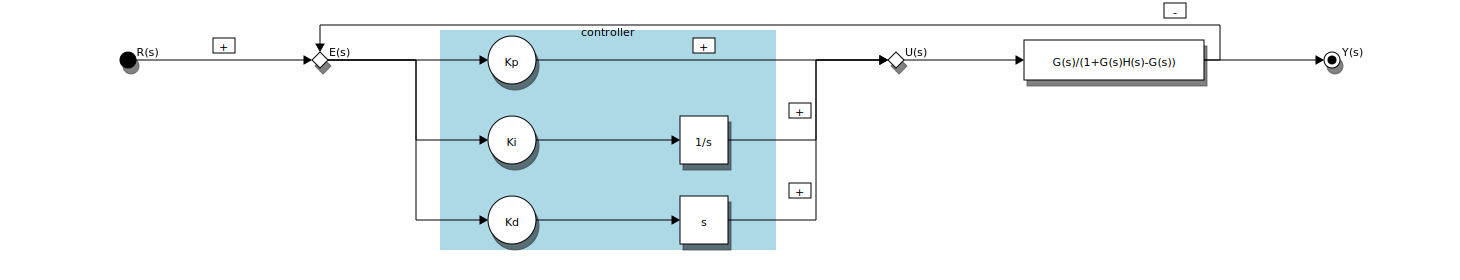

In [8]:
def create_blockdiag(source) -> SVG:
    tree = parser.parse_string(source)
    diagram = builder.ScreenNodeBuilder.build(tree)
    draw = drawer.DiagramDraw('SVG', diagram,filename='diag.svg')
    draw.drawer.set_options()
    draw.draw()
    return SVG(draw.save())

display(create_blockdiag("""
blockdiag {
  R [shape = beginpoint, label="R(s)"];
  Y [shape = endpoint, label="Y(s)"];
  E [shape = minidiamond, label="E(s)"];
  U [shape = minidiamond, label="U(s)"];
  group {
    label=controller
    color = lightblue
    Kp [shape = circle, label="Kp"];
    Ki [shape = circle, label="Ki"];
    Kd [shape = circle, label="Kd"];
    i [shape = square, label="1/s"];
    d [shape = square, label="s"];
    Ki -> i;
    Kd -> d;
  }
  GH [label="G(s)/(1+G(s)H(s)-G(s))", width=180];
  
  R -> E [label="+"];
  GH -> E [label="-"];
  E -> Kp;
  E -> Ki;
  E -> Kd;
  Kp -> U [label="+"];
  i -> U [label="+"];
  d -> U [label="+"];
  U -> GH -> Y;
}
"""))

In [9]:
%matplotlib widget

with plt.ioff():   # disable implicit display
    fig, axes = plt.subplots(1,3, figsize=(12,6))
    rl_ax, step_ax, impulse_ax = axes

rl_ax.set_title(f'root locus')
impulse_ax.set_title(f"impulse response")
step_ax.set_title(f"step response")

# p root locus
rlist, klist = control.rlocus(T, kvect=kvect, ax=rl_ax)
xlim = [-30, 1]
ylim = [-15, 15]
rl_ax.set_xlim(xlim)
rl_ax.set_ylim(ylim)

plots = {
    "poles": None,
    "step_response": None,
    "impulse_response": None
}
title = widgets.Label(f"$T(s)={T._repr_latex_().lstrip('$').rstrip('$')}$")
    
p_slider = widgets.FloatSlider(value=1, min=0.01, max=1000.0, step=0.01, orientation='horizontal')
i_slider = widgets.FloatSlider(value=0, min=0.00, max=10.0, step=0.01, orientation='horizontal')
d_slider = widgets.FloatSlider(value=0, min=0.00, max=100.0, step=0.01, orientation='horizontal')


def plot_gain_tf(p, i, d):
    C = control.tf(
        [d,p,i],
        [1,0]
    )
    TK = control.minreal((C * G) / (1 + C * G * H))
    fig.suptitle(
        f"$T_k(s)={TK._repr_latex_().lstrip('$').rstrip('$')}$\n"
    )
    
    # poles
    poles, zeros = control.pzmap(TK, plot=False)
    if plots["poles"] is not None:
        plots["poles"].remove()
    plots["poles"] = rl_ax.scatter(np.real(poles), np.imag(poles), c='pink')
    
    # step response
    step_x, step_y = control.step_response(TK)

    if plots["step_response"] is not None:
        plots["step_response"][0].set_data(step_x, step_y)
    else:
        plots["step_response"] = step_ax.plot(step_x, step_y)
        
    # impulse response
    impulse_x, impulse_y = control.impulse_response(TK)

    if plots["impulse_response"] is not None:
        plots["impulse_response"][0].set_data(impulse_x, impulse_y)
    else:
        plots["impulse_response"] = impulse_ax.plot(impulse_x, impulse_y)
    
sliders = interactive(plot_gain_tf, p=p_slider, i=i_slider, d=d_slider)

    
layout = widgets.AppLayout(
    center=fig.canvas,
    footer=sliders,
)
display(layout)

AppLayout(children=(interactive(children=(FloatSlider(value=1.0, description='p', max=1000.0, min=0.01, step=0…